# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future price behaviour from past price movements.
Here we implement it with USD/CAD rate as an example, but you can convert it to other market prices by getting other csv files.




In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

## Estruturando e Visualizando os Dados

In [2]:
# transformando dataframes de USDCAD e do PETRÓLEO BRENT

h = pd.read_csv('USDCAD_Candlestick_1_Hour_BID_31.12.2015-31.05.2018.csv')
o = pd.read_csv('BRENT.CMDUSD_Candlestick_1_Hour_BID_31.12.2014-31.05.2018.csv')

In [3]:
# Put USD/CAD hour data into Pandas Dataframe

df = pd.DataFrame(h)
display(df.head())
display(df.tail())

,Gmt time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0
1,01.01.2016 01:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0
2,01.01.2016 02:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0
3,01.01.2016 03:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0
4,01.01.2016 04:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0


,Gmt time,Open,High,Low,Close,Volume
15116,31.05.2018 19:00:00.000,1.29566,1.29671,1.29541,1.29666,5.330320e+09
15117,31.05.2018 20:00:00.000,1.29668,1.29682,1.29502,1.29563,3.116830e+09
15118,31.05.2018 21:00:00.000,1.29563,1.29577,1.29498,1.29564,1.456650e+09
15119,31.05.2018 22:00:00.000,1.29563,1.29563,1.29407,1.29409,1.370330e+09
15120,31.05.2018 23:00:00.000,1.29409,1.29469,1.29406,1.29436,1.259850e+09


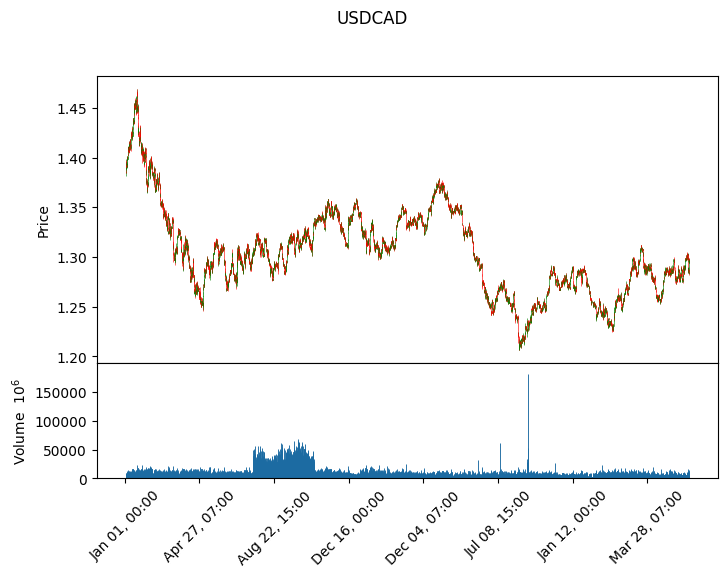

In [4]:
usd_cad = df.copy()
usd_cad.index = pd.to_datetime(usd_cad['Gmt time'])

# Renomeia as colunas para atender aos requisitos do mplfinance
usd_cad = usd_cad.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

# Define os parâmetros para o gráfico de candlestick
mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='candle', volume=True, figratio=(12,8), figscale=1.0, style=s, title='USDCAD', warn_too_much_data=100000)

# Cria o gráfico de candlestick com um gráfico de barras de volume
mpf.plot(usd_cad, **kwargs)

In [5]:
# Oil data

df_oil = pd.DataFrame(o)
display(df_oil.head())
display(df_oil.tail())

,Gmt time,Open,High,Low,Close,Volume
0,01.01.2015 00:00:00.000,56.83,56.83,56.83,56.83,0.0
1,01.01.2015 01:00:00.000,56.83,56.83,56.83,56.83,0.0
2,01.01.2015 02:00:00.000,56.83,56.83,56.83,56.83,0.0
3,01.01.2015 03:00:00.000,56.83,56.83,56.83,56.83,0.0
4,01.01.2015 04:00:00.000,56.83,56.83,56.83,56.83,0.0


,Gmt time,Open,High,Low,Close,Volume
21380,31.05.2018 19:00:00.000,77.835,77.865,77.625,77.655,102294.9964
21381,31.05.2018 20:00:00.000,77.655,77.788,77.535,77.725,125650.0036
21382,31.05.2018 21:00:00.000,77.725,77.725,77.725,77.725,0.0000
21383,31.05.2018 22:00:00.000,77.725,77.725,77.725,77.725,0.0000
21384,31.05.2018 23:00:00.000,77.725,77.725,77.725,77.725,0.0000


In [36]:
oil = df_oil.copy()
oil.index = pd.to_datetime(oil['Gmt time'])

# Renomeia as colunas para atender aos requisitos do mplfinance
oil = oil.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})

# Define os parâmetros para o gráfico de candlestick
mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)
kwargs = dict(type='candle', volume=True, figratio=(12,8), figscale=1.0, style=s, title='Oil',warn_too_much_data=100000)

# Cria o gráfico de candlestick com um gráfico de barras de volume
mpf.plot(oil, **kwargs)

KeyError: 'Gmt time'

In [7]:
# Set the date as datetime
df['datetime'] = pd.to_datetime(df['Gmt time'])

In [8]:
# Colocando a data como index
df = df.set_index(df['datetime'])
df.index.names = [None]
df

,Gmt time,Open,High,Low,Close,Volume,datetime
2016-01-01 00:00:00,01.01.2016 00:00:00.000,1.38326,1.38326,1.38326,1.38326,0.000000e+00,2016-01-01 00:00:00
2016-01-01 01:00:00,01.01.2016 01:00:00.000,1.38326,1.38326,1.38326,1.38326,0.000000e+00,2016-01-01 01:00:00
2016-01-01 02:00:00,01.01.2016 02:00:00.000,1.38326,1.38326,1.38326,1.38326,0.000000e+00,2016-01-01 02:00:00
2016-01-01 03:00:00,01.01.2016 03:00:00.000,1.38326,1.38326,1.38326,1.38326,0.000000e+00,2016-01-01 03:00:00
2016-01-01 04:00:00,01.01.2016 04:00:00.000,1.38326,1.38326,1.38326,1.38326,0.000000e+00,2016-01-01 04:00:00
...,...,...,...,...,...,...,...
2018-05-31 19:00:00,31.05.2018 19:00:00.000,1.29566,1.29671,1.29541,1.29666,5.330320e+09,2018-05-31 19:00:00
2018-05-31 20:00:00,31.05.2018 20:00:00.000,1.29668,1.29682,1.29502,1.29563,3.116830e+09,2018-05-31 20:00:00
2018-05-31 21:00:00,31.05.2018 21:00:00.000,1.29563,1.29577,1.29498,1.29564,1.456650e+09,2018-05-31 21:00:00
2018-05-31 22:00:00,31.05.2018 22:00:00.000,1.29563,1.29563,1.29407,1.29409,1.370330e+09,2018-05-31 22:00:00


In [9]:
# Set datetime for oil

df_oil['datetime'] = pd.to_datetime(df_oil['Gmt time'])
df_oil = df_oil.set_index(df_oil['datetime'])
df_oil.index.names = [None]
df_oil

,Gmt time,Open,High,Low,Close,Volume,datetime
2015-01-01 00:00:00,01.01.2015 00:00:00.000,56.830,56.830,56.830,56.830,0.0000,2015-01-01 00:00:00
2015-01-01 01:00:00,01.01.2015 01:00:00.000,56.830,56.830,56.830,56.830,0.0000,2015-01-01 01:00:00
2015-01-01 02:00:00,01.01.2015 02:00:00.000,56.830,56.830,56.830,56.830,0.0000,2015-01-01 02:00:00
2015-01-01 03:00:00,01.01.2015 03:00:00.000,56.830,56.830,56.830,56.830,0.0000,2015-01-01 03:00:00
2015-01-01 04:00:00,01.01.2015 04:00:00.000,56.830,56.830,56.830,56.830,0.0000,2015-01-01 04:00:00
...,...,...,...,...,...,...,...
2018-05-31 19:00:00,31.05.2018 19:00:00.000,77.835,77.865,77.625,77.655,102294.9964,2018-05-31 19:00:00
2018-05-31 20:00:00,31.05.2018 20:00:00.000,77.655,77.788,77.535,77.725,125650.0036,2018-05-31 20:00:00
2018-05-31 21:00:00,31.05.2018 21:00:00.000,77.725,77.725,77.725,77.725,0.0000,2018-05-31 21:00:00
2018-05-31 22:00:00,31.05.2018 22:00:00.000,77.725,77.725,77.725,77.725,0.0000,2018-05-31 22:00:00


In [10]:
df_oil = df_oil.loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]

df_oil = df_oil.rename(columns={'Open': 'Open_oil', 'High': 'High_oil', 'Low':'Low_oil', 'Close':'Close_oil', 'Volume':'Volume_oil'})

df_oil.tail()

,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil
2018-05-31 19:00:00,77.835,77.865,77.625,77.655,102294.9964
2018-05-31 20:00:00,77.655,77.788,77.535,77.725,125650.0036
2018-05-31 21:00:00,77.725,77.725,77.725,77.725,0.0000
2018-05-31 22:00:00,77.725,77.725,77.725,77.725,0.0000
2018-05-31 23:00:00,77.725,77.725,77.725,77.725,0.0000


<Axes: >

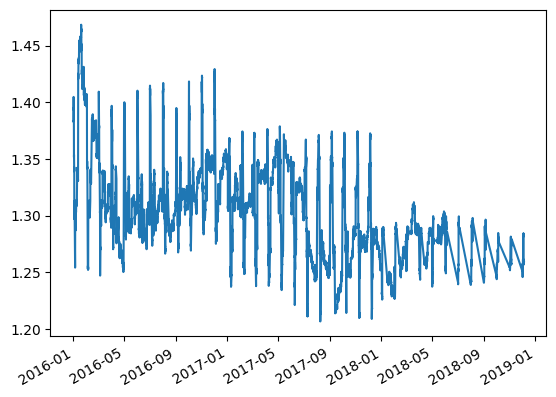

In [11]:
# Just some exploration 

df['Close'].plot()

<Axes: >

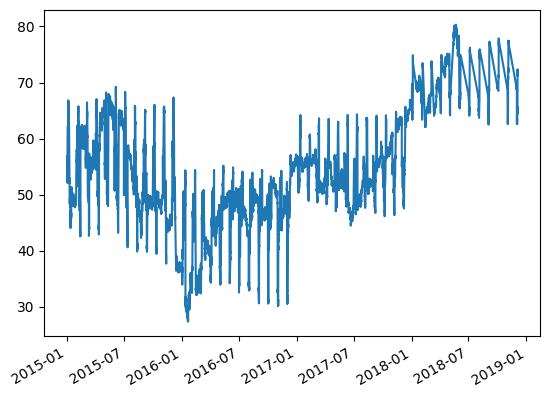

In [12]:
df_oil['Close_oil'].plot()

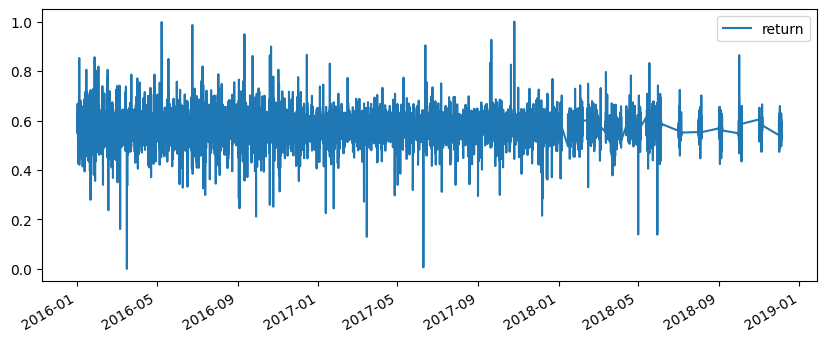

In [13]:
# Create return (close-open) normalized

df['return_next'] = df['Close'].shift(-1) - df['Open'].shift(-1)
return_range = df['return_next'].max() - df['return_next'].min()
df['return_next'] = df['return_next'] / return_range

df['return'] = df['Close'] - df['Open']
return_range = df['return'].max() - df['return'].min()
df['return'] = (df['return'] - df['return'].min()) / return_range

df.plot(y='return', figsize=(10,4))

plt.show()

In [14]:
df.shift(-1).head()

,Gmt time,Open,High,Low,Close,Volume,datetime,return_next,return
2016-01-01 00:00:00,01.01.2016 01:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0,2016-01-01 01:00:00,0.0,0.57152
2016-01-01 01:00:00,01.01.2016 02:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0,2016-01-01 02:00:00,0.0,0.57152
2016-01-01 02:00:00,01.01.2016 03:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0,2016-01-01 03:00:00,0.0,0.57152
2016-01-01 03:00:00,01.01.2016 04:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0,2016-01-01 04:00:00,0.0,0.57152
2016-01-01 04:00:00,01.01.2016 05:00:00.000,1.38326,1.38326,1.38326,1.38326,0.0,2016-01-01 05:00:00,0.0,0.57152


In [15]:
df.shift(-1).tail()

,Gmt time,Open,High,Low,Close,Volume,datetime,return_next,return
2018-05-31 19:00:00,31.05.2018 20:00:00.000,1.29668,1.29682,1.29502,1.29563,3.116830e+09,2018-05-31 20:00:00,0.000321,0.537769
2018-05-31 20:00:00,31.05.2018 21:00:00.000,1.29563,1.29577,1.29498,1.29564,1.456650e+09,2018-05-31 21:00:00,-0.049502,0.571842
2018-05-31 21:00:00,31.05.2018 22:00:00.000,1.29563,1.29563,1.29407,1.29409,1.370330e+09,2018-05-31 22:00:00,0.008679,0.522019
2018-05-31 22:00:00,31.05.2018 23:00:00.000,1.29409,1.29469,1.29406,1.29436,1.259850e+09,2018-05-31 23:00:00,NaN,0.580199
2018-05-31 23:00:00,None,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [16]:
# Make label, 1 as rising price, 0 as falling price - prediction for the following timestamp
# ****************** consider when return ==0 next version

df['label'] = df['return_next'].apply(lambda x: 1 if x>0.0 else 0)
df.tail(10)

,Gmt time,Open,High,Low,Close,Volume,datetime,return_next,return,label
2018-05-31 14:00:00,31.05.2018 14:00:00.000,1.29518,1.29770,1.29430,1.29718,9.841480e+09,2018-05-31 14:00:00,-0.005464,0.635808,0
2018-05-31 15:00:00,31.05.2018 15:00:00.000,1.29716,1.29903,1.29586,1.29699,1.169860e+10,2018-05-31 15:00:00,-0.045002,0.566056,0
2018-05-31 16:00:00,31.05.2018 16:00:00.000,1.29699,1.29750,1.29555,1.29559,7.277670e+09,2018-05-31 16:00:00,0.072324,0.526519,1
2018-05-31 17:00:00,31.05.2018 17:00:00.000,1.29560,1.29803,1.29424,1.29785,7.262840e+09,2018-05-31 17:00:00,-0.071038,0.643844,0
2018-05-31 18:00:00,31.05.2018 18:00:00.000,1.29785,1.29884,1.29538,1.29564,6.044530e+09,2018-05-31 18:00:00,0.032144,0.500482,1
2018-05-31 19:00:00,31.05.2018 19:00:00.000,1.29566,1.29671,1.29541,1.29666,5.330320e+09,2018-05-31 19:00:00,-0.033751,0.603664,0
2018-05-31 20:00:00,31.05.2018 20:00:00.000,1.29668,1.29682,1.29502,1.29563,3.116830e+09,2018-05-31 20:00:00,0.000321,0.537769,1
2018-05-31 21:00:00,31.05.2018 21:00:00.000,1.29563,1.29577,1.29498,1.29564,1.456650e+09,2018-05-31 21:00:00,-0.049502,0.571842,0
2018-05-31 22:00:00,31.05.2018 22:00:00.000,1.29563,1.29563,1.29407,1.29409,1.370330e+09,2018-05-31 22:00:00,0.008679,0.522019,1
2018-05-31 23:00:00,31.05.2018 23:00:00.000,1.29409,1.29469,1.29406,1.29436,1.259850e+09,2018-05-31 23:00:00,NaN,0.580199,0


In [17]:
# The last register shows a NaN

df.dropna(inplace=True)
df.tail()

,Gmt time,Open,High,Low,Close,Volume,datetime,return_next,return,label
2018-05-31 18:00:00,31.05.2018 18:00:00.000,1.29785,1.29884,1.29538,1.29564,6.044530e+09,2018-05-31 18:00:00,0.032144,0.500482,1
2018-05-31 19:00:00,31.05.2018 19:00:00.000,1.29566,1.29671,1.29541,1.29666,5.330320e+09,2018-05-31 19:00:00,-0.033751,0.603664,0
2018-05-31 20:00:00,31.05.2018 20:00:00.000,1.29668,1.29682,1.29502,1.29563,3.116830e+09,2018-05-31 20:00:00,0.000321,0.537769,1
2018-05-31 21:00:00,31.05.2018 21:00:00.000,1.29563,1.29577,1.29498,1.29564,1.456650e+09,2018-05-31 21:00:00,-0.049502,0.571842,0
2018-05-31 22:00:00,31.05.2018 22:00:00.000,1.29563,1.29563,1.29407,1.29409,1.370330e+09,2018-05-31 22:00:00,0.008679,0.522019,1


In [18]:
df2 = df.copy()

df = df.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'return', 'label']]
df.tail()

,Open,High,Low,Close,Volume,return,label
2018-05-31 18:00:00,1.29785,1.29884,1.29538,1.29564,6.044530e+09,0.500482,1
2018-05-31 19:00:00,1.29566,1.29671,1.29541,1.29666,5.330320e+09,0.603664,0
2018-05-31 20:00:00,1.29668,1.29682,1.29502,1.29563,3.116830e+09,0.537769,1
2018-05-31 21:00:00,1.29563,1.29577,1.29498,1.29564,1.456650e+09,0.571842,0
2018-05-31 22:00:00,1.29563,1.29563,1.29407,1.29409,1.370330e+09,0.522019,1


In [19]:
df = pd.concat([df,df_oil],axis=1, join='inner')
df.head()

,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil
2016-01-01 00:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0
2016-01-01 01:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0
2016-01-01 02:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0
2016-01-01 03:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0
2016-01-01 04:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0


In [20]:
df.tail()

,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil
2018-05-31 18:00:00,1.29785,1.29884,1.29538,1.29564,6.044530e+09,0.500482,1,77.156,77.891,76.935,77.835,405591.9945
2018-05-31 19:00:00,1.29566,1.29671,1.29541,1.29666,5.330320e+09,0.603664,0,77.835,77.865,77.625,77.655,102294.9964
2018-05-31 20:00:00,1.29668,1.29682,1.29502,1.29563,3.116830e+09,0.537769,1,77.655,77.788,77.535,77.725,125650.0036
2018-05-31 21:00:00,1.29563,1.29577,1.29498,1.29564,1.456650e+09,0.571842,0,77.725,77.725,77.725,77.725,0.0000
2018-05-31 22:00:00,1.29563,1.29563,1.29407,1.29409,1.370330e+09,0.522019,1,77.725,77.725,77.725,77.725,0.0000


In [21]:
# Creating datetime features


df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

df['hour'] = df.index.hour


df.head()

,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2016-01-01 00:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,0
2016-01-01 01:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,1
2016-01-01 02:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,2
2016-01-01 03:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,3
2016-01-01 04:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,4


In [22]:
df.dtypes

# we have to change the volume type later

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
return        float64
label           int64
Open_oil      float64
High_oil      float64
Low_oil       float64
Close_oil     float64
Volume_oil    float64
year            int64
month           int64
day             int64
hour            int64
dtype: object

## Escolhendo um DataFrame para o Trade

In [23]:
# Limiting the dataframe: from 3:00 to 12:00 (10 timestamps) 

df = df.between_time(include_start=True,include_end=True, start_time='03:00:00', end_time='12:00:00')
df.tail(20)

C:\Users\arthu\AppData\Local\Temp\ipykernel_1136\1837619197.py:3: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  df = df.between_time(include_start=True,include_end=True, start_time='03:00:00', end_time='12:00:00')


,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2018-05-30 03:00:00,1.30247,1.30350,1.30238,1.30303,2.623410e+09,0.589521,0,74.916,74.971,74.845,74.911,22219.0004,2018,5,30,3
2018-05-30 04:00:00,1.30306,1.30314,1.30230,1.30260,1.692350e+09,0.556734,1,74.906,75.256,74.875,75.210,23346.9997,2018,5,30,4
2018-05-30 05:00:00,1.30259,1.30398,1.30234,1.30262,3.642960e+09,0.572485,0,75.201,75.231,74.956,75.071,29354.0005,2018,5,30,5
2018-05-30 06:00:00,1.30266,1.30302,1.30143,1.30222,7.352290e+09,0.557377,0,75.076,75.411,75.051,75.331,48622.9993,2018,5,30,6
2018-05-30 07:00:00,1.30218,1.30279,1.30109,1.30148,7.621840e+09,0.549020,0,75.341,75.421,75.165,75.411,223709.0021,2018,5,30,7
2018-05-30 08:00:00,1.30152,1.30161,1.30047,1.30047,7.426750e+09,0.537769,0,75.395,75.495,75.195,75.475,232400.9985,2018,5,30,8
2018-05-30 09:00:00,1.30047,1.30049,1.29931,1.29958,7.103510e+09,0.542912,0,75.475,75.915,75.430,75.820,386076.0033,2018,5,30,9
2018-05-30 10:00:00,1.29959,1.29999,1.29813,1.29861,8.318910e+09,0.540019,0,75.815,75.835,75.505,75.635,319040.0004,2018,5,30,10
2018-05-30 11:00:00,1.29863,1.29885,1.29705,1.29715,6.624660e+09,0.523947,1,75.630,76.040,75.570,76.035,354658.0076,2018,5,30,11
2018-05-30 12:00:00,1.29717,1.29863,1.29527,1.29781,1.067015e+10,0.592093,1,76.035,76.295,75.935,76.015,572080.0161,2018,5,30,12


In [24]:
df.head(10)

,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2016-01-01 03:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,3
2016-01-01 04:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,4
2016-01-01 05:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,5
2016-01-01 06:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,6
2016-01-01 07:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,7
2016-01-01 08:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,8
2016-01-01 09:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,9
2016-01-01 10:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,10
2016-01-01 11:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,11
2016-01-01 12:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,12


In [25]:
# Make training and test dataset

df_test = df.loc['2018-05-01':'2018-05-31' ,:]  
display(df_test.head())
display(df_test.tail())

df_train = df.loc[:'2018-04-30',:] 
display(df_train.head())
display(df_train.tail())

C:\Users\arthu\AppData\Local\Temp\ipykernel_1136\1148158352.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_test = df.loc['2018-05-01':'2018-05-31' ,:]


,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2018-05-01 03:00:00,1.24915,1.24925,1.24836,1.24875,2.587190e+09,0.558663,0,67.95,67.975,67.905,67.945,16400.0001,2018,5,1,3
2018-05-01 04:00:00,1.24875,1.24889,1.24844,1.24845,2.972600e+09,0.561877,1,67.95,68.010,67.945,67.995,11629.9996,2018,5,1,4
2018-05-01 05:00:00,1.24844,1.24938,1.24844,1.24922,2.884640e+09,0.596593,1,67.99,68.040,67.965,67.980,27775.9992,2018,5,1,5
2018-05-01 06:00:00,1.24923,1.25064,1.24898,1.25047,4.153540e+09,0.611379,1,67.98,68.010,67.875,67.905,29696.9991,2018,5,1,6
2018-05-01 07:00:00,1.25047,1.25075,1.24961,1.25074,5.663920e+09,0.580199,0,67.91,67.910,67.750,67.775,75609.9969,2018,5,1,7


,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2018-05-31 08:00:00,1.28484,1.28538,1.28356,1.28400,5.385360e+09,0.544519,1,77.505,77.580,77.285,77.315,260250.0021,2018,5,31,8
2018-05-31 09:00:00,1.28400,1.28539,1.28394,1.28470,5.552970e+09,0.594021,0,77.346,77.446,77.185,77.215,167003.0057,2018,5,31,9
2018-05-31 10:00:00,1.28472,1.28583,1.28180,1.28259,5.881380e+09,0.503054,1,77.221,77.496,77.165,77.395,133186.9960,2018,5,31,10
2018-05-31 11:00:00,1.28264,1.28514,1.28251,1.28474,6.608530e+09,0.639023,1,77.416,77.891,77.365,77.826,255546.9871,2018,5,31,11
2018-05-31 12:00:00,1.28474,1.28987,1.28472,1.28985,1.079586e+10,0.735776,1,77.821,78.201,77.615,78.121,309336.0066,2018,5,31,12


,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2016-01-01 03:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,3
2016-01-01 04:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,4
2016-01-01 05:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,5
2016-01-01 06:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,6
2016-01-01 07:00:00,1.38326,1.38326,1.38326,1.38326,0.0,0.57152,0,37.704,37.704,37.704,37.704,0.0,2016,1,1,7


,Open,High,Low,Close,Volume,return,label,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour
2018-04-05 08:00:00,1.28627,1.28750,1.28572,1.28749,3.296140e+09,0.610736,0,73.500,73.515,73.285,73.310,116010.0028,2018,4,5,8
2018-04-05 09:00:00,1.28751,1.28798,1.28696,1.28736,3.392910e+09,0.566699,0,73.305,73.530,73.225,73.520,79392.9994,2018,4,5,9
2018-04-05 10:00:00,1.28735,1.28779,1.28699,1.28699,2.091400e+09,0.559949,1,73.515,74.010,73.510,73.985,127573.9968,2018,4,5,10
2018-04-05 11:00:00,1.28698,1.28758,1.28665,1.28699,4.170160e+09,0.571842,0,73.980,74.045,73.670,73.735,150076.0019,2018,4,5,11
2018-04-05 12:00:00,1.28704,1.28818,1.28424,1.28651,1.092947e+10,0.554484,1,73.725,74.040,73.720,73.885,219163.0006,2018,4,5,12


In [26]:
df_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'return', 'label', 'Open_oil',
       'High_oil', 'Low_oil', 'Close_oil', 'Volume_oil', 'year', 'month',
       'day', 'hour'],
      dtype='object')

## Treinando o Modelo

In [27]:
# Separate features and output

y_train = df_train['label']
X_train = df_train.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'return', 'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 'Volume_oil',
       'year', 'month', 'day', 'hour']]

y_test = df_test['label']
X_test = df_test.loc[:,['Open', 'High', 'Low', 'Close', 'Volume', 'return', 'Open_oil', 'High_oil', 'Low_oil', 'Close_oil', 'Volume_oil',
       'year', 'month', 'day', 'hour']]


In [28]:
print(X_test.shape)
print(y_test.shape)

print('%% of Class0 : %f y_test' % (np.count_nonzero(y_test == 0)/float(len(y_test))))
print('%% of Class1 : %f y_test' % (np.count_nonzero(y_test == 1)/float(len(y_test))))

(180, 15)
(180,)
% of Class0 : 0.444444 y_test
% of Class1 : 0.555556 y_test


In [29]:
print(X_train.shape)
print(y_train.shape)

print('%% of Class0 : %f y_train' % (np.count_nonzero(y_train == 0)/float(len(y_train))))
print('%% of Class1 : %f y_train' % (np.count_nonzero(y_train == 1)/float(len(y_train))))

(5870, 15)
(5870,)
% of Class0 : 0.498126 y_train
% of Class1 : 0.501874 y_train


In [30]:
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=1000, verbose=3)

scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3861           19.98s
         2           1.3859           19.46s
         3           1.3857           19.28s
         4           1.3855           19.17s
         5           1.3853           19.10s
         6           1.3851           19.22s
         7           1.3849           19.01s
         8           1.3848           18.97s
         9           1.3846           18.94s
        10           1.3844           18.91s
        11           1.3843           18.88s
        12           1.3841           18.85s
        13           1.3839           18.83s
        14           1.3838           18.80s
        15           1.3836           18.78s
        16           1.3835           18.76s
        17           1.3833           18.68s
        18           1.3831           18.66s
        19           1.3830           18.64s
        20           1.3829           18.57s
        21           1.3827           18.55s
        2

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=0, verbose=3)

## Testando o Model

In [31]:
accuracy = clf.score(X_train, y_train)
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.654855


In [32]:
# Predict test data

pred = clf.predict(X_test)

In [33]:
# Comparing predicted and label

df_trade = pd.DataFrame(X_test)
df_trade['label']  = y_test
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']

df_trade

,Open,High,Low,Close,Volume,return,Open_oil,High_oil,Low_oil,Close_oil,Volume_oil,year,month,day,hour,label,pred,won
2018-05-01 03:00:00,1.24915,1.24925,1.24836,1.24875,2.587190e+09,0.558663,67.950,67.975,67.905,67.945,16400.0001,2018,5,1,3,0,1,False
2018-05-01 04:00:00,1.24875,1.24889,1.24844,1.24845,2.972600e+09,0.561877,67.950,68.010,67.945,67.995,11629.9996,2018,5,1,4,1,1,True
2018-05-01 05:00:00,1.24844,1.24938,1.24844,1.24922,2.884640e+09,0.596593,67.990,68.040,67.965,67.980,27775.9992,2018,5,1,5,1,0,False
2018-05-01 06:00:00,1.24923,1.25064,1.24898,1.25047,4.153540e+09,0.611379,67.980,68.010,67.875,67.905,29696.9991,2018,5,1,6,1,0,False
2018-05-01 07:00:00,1.25047,1.25075,1.24961,1.25074,5.663920e+09,0.580199,67.910,67.910,67.750,67.775,75609.9969,2018,5,1,7,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-31 08:00:00,1.28484,1.28538,1.28356,1.28400,5.385360e+09,0.544519,77.505,77.580,77.285,77.315,260250.0021,2018,5,31,8,1,1,True
2018-05-31 09:00:00,1.28400,1.28539,1.28394,1.28470,5.552970e+09,0.594021,77.346,77.446,77.185,77.215,167003.0057,2018,5,31,9,0,1,False
2018-05-31 10:00:00,1.28472,1.28583,1.28180,1.28259,5.881380e+09,0.503054,77.221,77.496,77.165,77.395,133186.9960,2018,5,31,10,1,1,True
2018-05-31 11:00:00,1.28264,1.28514,1.28251,1.28474,6.608530e+09,0.639023,77.416,77.891,77.365,77.826,255546.9871,2018,5,31,11,1,1,True


In [34]:
# Didnt won and won

print(df_trade[df_trade['won'] == False]['won'].count())
print(df_trade[df_trade['won'] == True]['won'].count())

79
101


In [35]:
# % of won

df_trade[df_trade['won'] == True]['won'].count()/df_trade['won'].count()

0.5611111111111111